In [13]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import Counter

api = wandb.Api()

In [14]:
runs = api.runs("qba/rehersal Alexnet MNIST Task IL tr-t split v2")

In [15]:
runs_list = []

for run in runs:
    runs_list.append(run.config)

df = pd.DataFrame(runs_list)

In [16]:
df

,setup,epochs,dataset,architecture,learning_rate,rehearsal_dataset
0,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,
1,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,
2,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,
3,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,
4,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,
5,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,stylegan-random
6,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,stylegan-random
7,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,stylegan-random
8,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,stylegan-random
9,task IL,5,CIFAR10,SmallAlexNetTasklIL,0.01,stylegan-random


In [17]:
df = runs[0].history(samples=10000)

In [18]:
acc_col = ['acc_task_0', 'acc_task_1', 'acc_task_2', 'acc_task_3', 'acc_task_4']
acc_test_col = ['acc_test_task_0', 'acc_test_task_1', 'acc_test_task_2', 'acc_test_task_3', 'acc_test_task_4']
cols = ['acc_task_0', 'acc_task_1', 'acc_task_2', 'acc_task_3', 'acc_task_4', '_step']

In [19]:
dfs = {}
dfs_test = {}

counter = Counter()

for run in runs:
    curr_dataset = run.config['rehearsal_dataset']
    try:
        curr_run = run.history(samples=10000)
        if curr_dataset in list(dfs.keys()):
            dfs[curr_dataset] += curr_run[acc_test_col].dropna().reset_index().drop(columns='index')
            dfs_test[curr_dataset] += curr_run[acc_col].dropna().reset_index().drop(columns='index')
        else:
            dfs[curr_dataset] = curr_run[acc_test_col].dropna().reset_index().drop(columns='index')
            dfs_test[curr_dataset] = curr_run[acc_col].dropna().reset_index().drop(columns='index')

        counter.update({curr_dataset:1})
    except:
        pass

for k, v in counter.items():
    dfs[k] /= v
    dfs_test[k] /= v

In [25]:
curr_run

,acc_task_2,_step,_runtime,acc_task_1,acc_task_0,acc_task_3,_timestamp,acc_task_4,acc_test_task_4,acc_test_task_1,acc_test_task_2,acc_test_task_3,acc_test_task_0,loss
0,50.0,0,16.724322,49.150002,50.0,49.98,1.694993e+09,50.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,16.724717,NaN,NaN,NaN,1.694993e+09,NaN,50.0,49.549999,50.0,49.950001,50.0,NaN
2,NaN,2,16.726207,NaN,NaN,NaN,1.694993e+09,NaN,NaN,NaN,NaN,NaN,NaN,1.474298
3,NaN,3,16.764580,NaN,NaN,NaN,1.694993e+09,NaN,NaN,NaN,NaN,NaN,NaN,2.529776
4,NaN,4,16.807667,NaN,NaN,NaN,1.694993e+09,NaN,NaN,NaN,NaN,NaN,NaN,9.054437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,NaN,2370,2040.199616,NaN,NaN,NaN,1.694995e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.743245
2371,NaN,2371,2040.250165,NaN,NaN,NaN,1.694995e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.781047
2372,NaN,2372,2040.290174,NaN,NaN,NaN,1.694995e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.766497
2373,NaN,2373,2040.329785,NaN,NaN,NaN,1.694995e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.758231


In [23]:
dfs[dataset]

,acc_test_task_0,acc_test_task_1,acc_test_task_2,acc_test_task_3,acc_test_task_4
0,70.000000,50.060000,50.000000,43.800000,51.310001
1,70.030000,48.500000,48.940000,49.730000,51.710000
2,50.269999,44.390000,48.650000,48.000000,51.320000
3,52.260000,46.490000,52.410001,50.299999,52.290001
4,77.060000,45.620000,52.270000,48.860000,51.970000
...,...,...,...,...,...
195,81.710002,70.260000,81.639998,73.280000,81.259999
196,82.150002,72.599999,85.690001,73.899999,81.300000
197,83.179998,72.999998,83.120000,75.669998,86.160001
198,82.090001,70.979999,82.440001,73.149998,86.010001


In [24]:
dfs_test[dataset]

,acc_task_0,acc_task_1,acc_task_2,acc_task_3,acc_task_4
0,70.000000,50.158000,49.998000,43.862000,50.896000
1,70.106000,48.436000,49.367999,49.850000,51.136000
2,50.290001,45.410000,49.578000,47.688000,50.600000
3,52.134000,47.476000,51.864000,49.678000,51.318000
4,77.142000,46.342001,52.216000,49.282000,50.916000
...,...,...,...,...,...
195,81.754001,71.583998,83.074001,73.762001,85.006000
196,82.284000,73.443999,86.414000,74.125999,86.210001
197,83.370001,74.350001,84.334001,76.033999,91.260001
198,82.162001,71.733999,83.892000,73.314001,91.453999


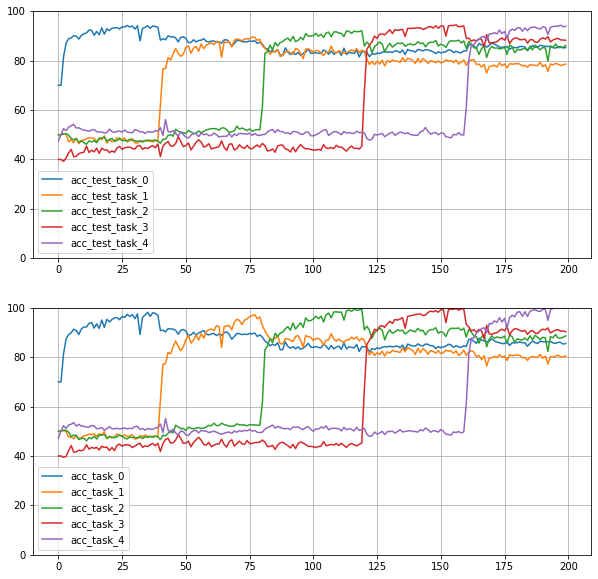

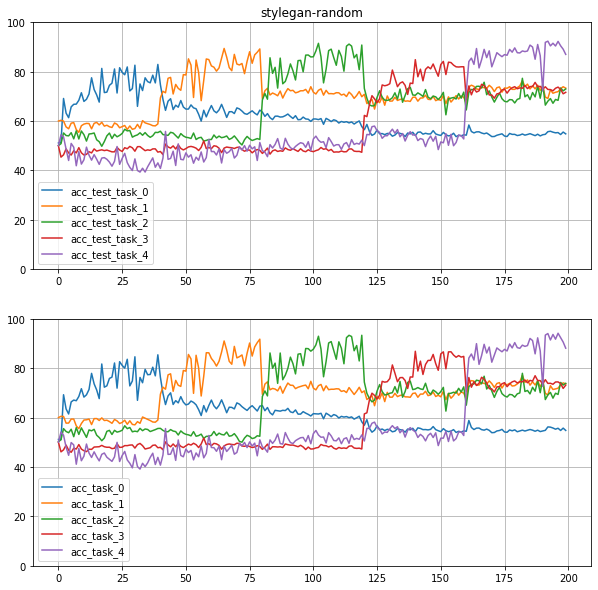

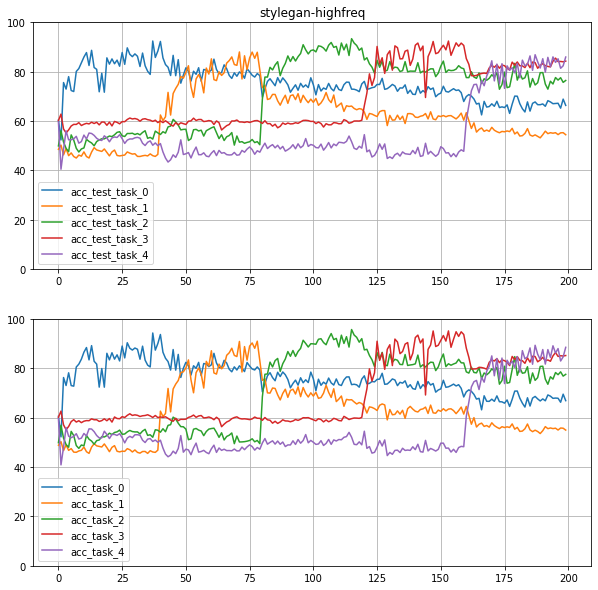

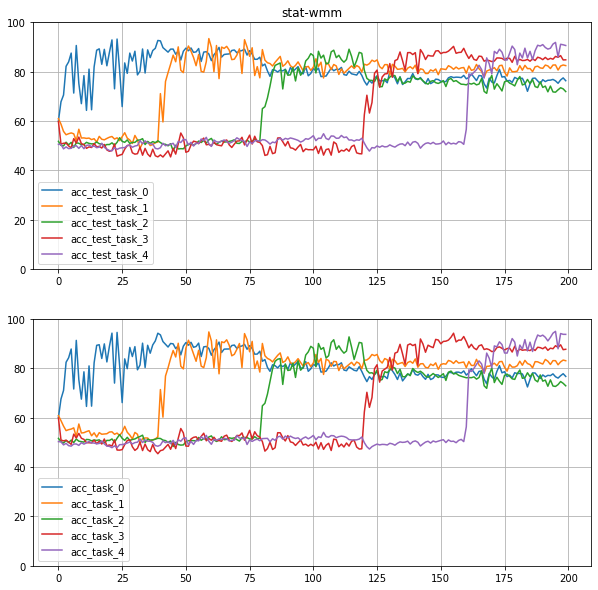

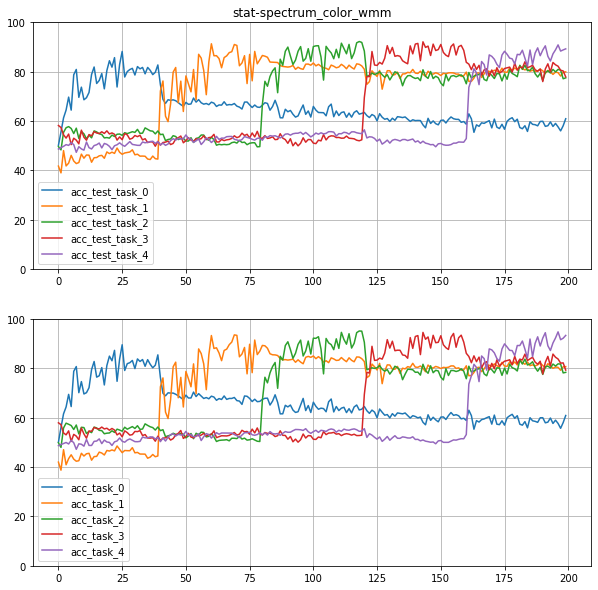

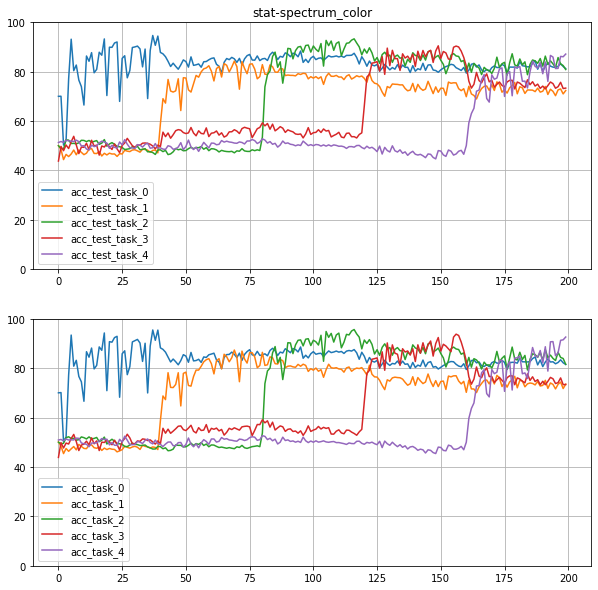

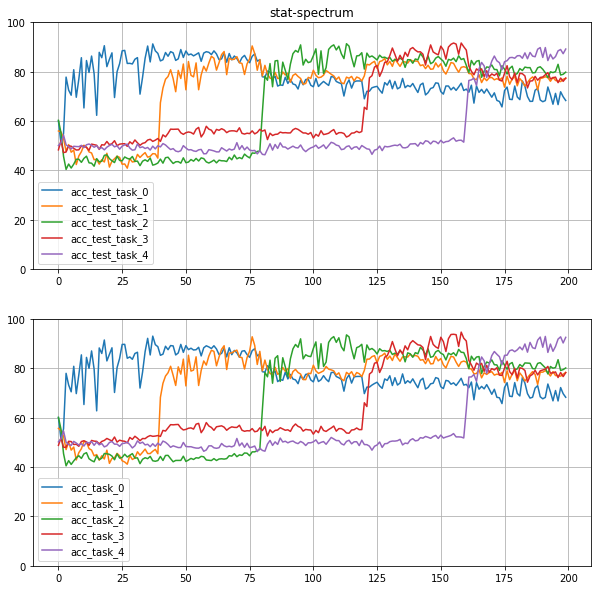

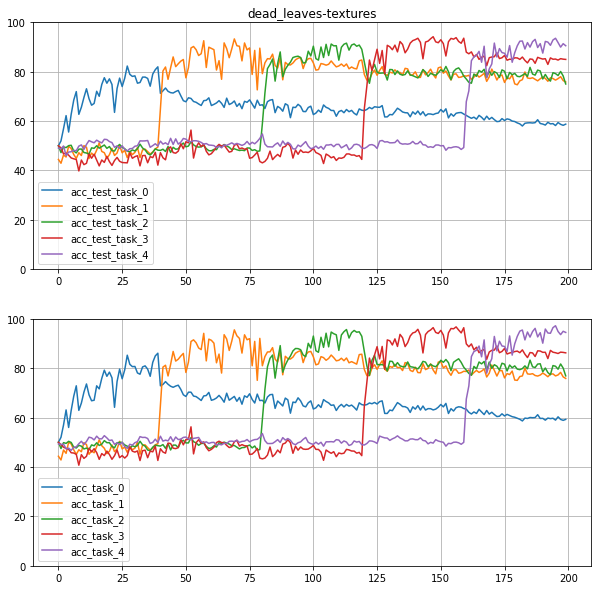

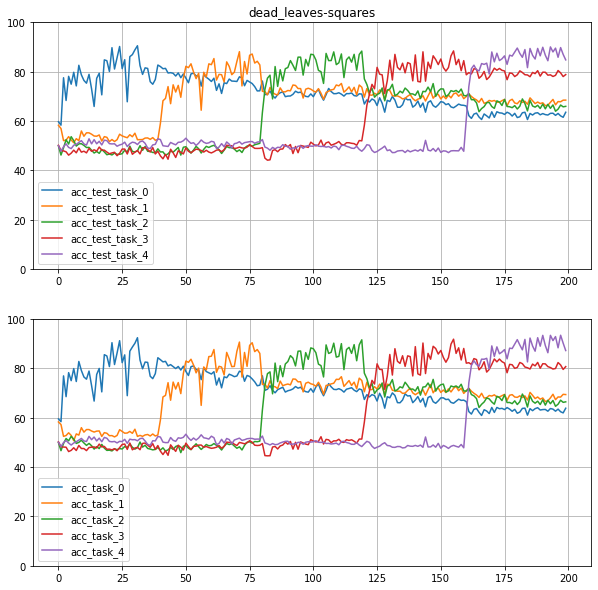

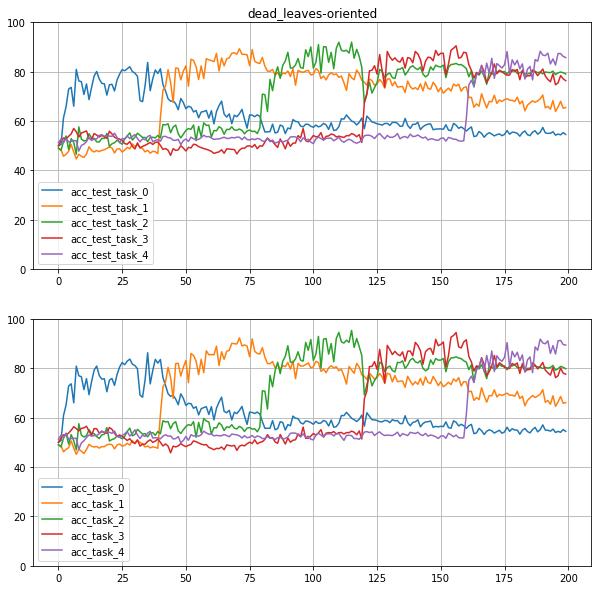

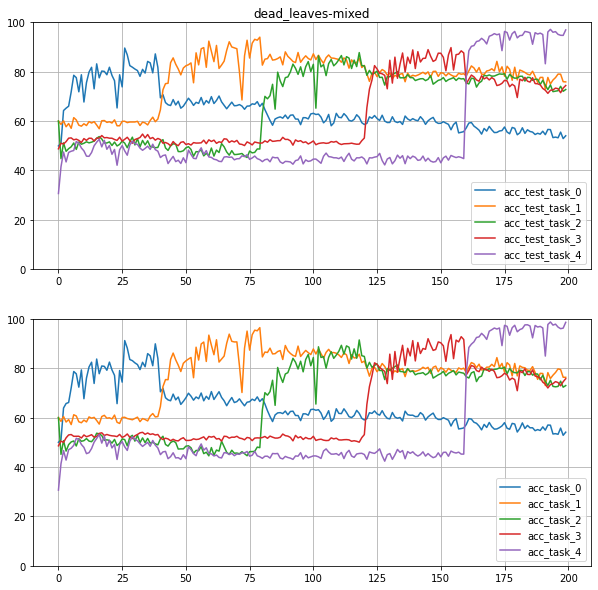

In [20]:
for dataset in list(dfs.keys()):
    fig, ax = plt.subplots(2,1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    dfs[dataset].plot(ax=ax[0], grid=True ,ylim=[0, 100],title=dataset)
    plt.ylim([0,100])
    dfs_test[dataset].plot(ax=ax[1], grid=True ,ylim=[0, 100])
    plt.ylim([0,100])

None compare to stat-spectrum

In [21]:
list(dfs.keys())

['',
 'stylegan-random',
 'stylegan-highfreq',
 'stat-wmm',
 'stat-spectrum_color_wmm',
 'stat-spectrum_color',
 'stat-spectrum',
 'dead_leaves-textures',
 'dead_leaves-squares',
 'dead_leaves-oriented',
 'dead_leaves-mixed']

<AxesSubplot:>

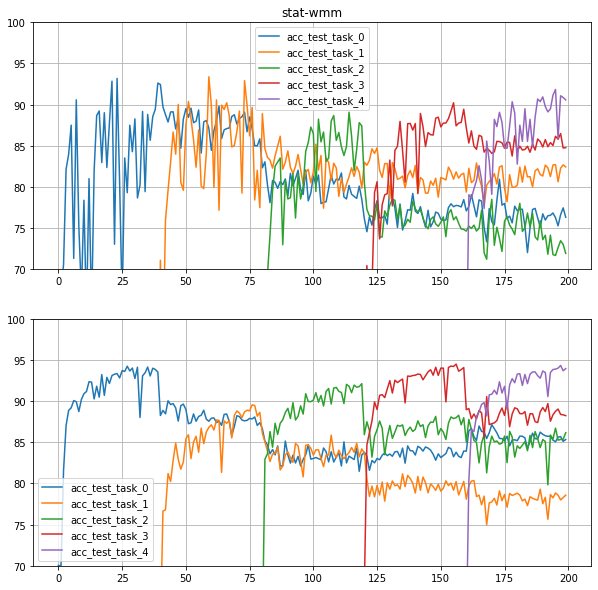

In [31]:
dataset = 'stat-wmm'

fig, ax = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(10)
dfs[dataset].plot(ax=ax[0], grid=True, ylim=[70, 100], title=dataset)
dfs[''].plot(ax=ax[1], grid=True, ylim=[70, 100], title='')


# MESS

In [ ]:
# dfs = {}

# for i in range(len(runs)):
#     print(f"{runs[i].name}")
#     dfs[i] = runs[i].history(samples=10000)
#     print(len(dfs[i][cols].dropna().sort_values(by='_step').set_index('_step')))

In [ ]:
dfs = {}

for i in range(len(runs)):
    print(f"{runs[i].name}")
    if runs[i].name in noise_rehersal_runs:
        dfs[i] = runs[i].history(samples=10000)
        print(len(dfs[i][cols].dropna().sort_values(by='_step').set_index('_step')))

In [ ]:
df = dfs[1]

for i in range(len(acc_col)):
    plt.plot(df[[acc_col[i],'_step']].dropna().sort_values(by='_step').set_index('_step'))

plt.legend(acc_col)
plt.show()

In [ ]:
df_all_runs = pd.DataFrame()

for i in dfs.keys():
    df_all_runs = pd.concat([df_all_runs, dfs[i][acc_col].dropna()])

df_all_runs.reset_index().groupby("index").mean().plot()

# REHERSAL

In [ ]:
runs = api.runs("qba/rehersal small net MNIST Task IL")

In [ ]:
noise_rehersal_runs = [
'vibrant-sunset-34',
'eager-smoke-33',
'magic-glade-32'
]

acc_col = ['acc_task_0', 'acc_task_1', 'acc_task_2', 'acc_task_3', 'acc_task_4']
cols = ['acc_task_0', 'acc_task_1', 'acc_task_2', 'acc_task_3', 'acc_task_4', '_step']

In [ ]:
dfs_rehersal = {}

for i in range(len(runs)):
    print(f"{runs[i].name}")
    if runs[i].name in noise_rehersal_runs:
        dfs_rehersal[i] = runs[i].history(samples=10000)
        print(len(dfs[i][cols].dropna().sort_values(by='_step').set_index('_step')))

# Single run

In [ ]:
df = dfs_rehersal[1]

for i in range(len(acc_col)):
    plt.plot(df[[acc_col[i],'_step']].dropna().sort_values(by='_step').set_index('_step'))

plt.legend(acc_col)
plt.show()

# All runs mean

In [ ]:
df_all_runs_rehersal = pd.DataFrame()

for i in dfs_rehersal.keys():
    df_all_runs_rehersal = pd.concat([df_all_runs_rehersal, dfs_rehersal[i][acc_col].dropna()])

df_all_runs_rehersal.reset_index().groupby("index").mean().plot()

# Comparison

In [ ]:
plt.figure(figsize=(20,10))
legend = []

for task_num in range(5):
    plt.plot(df_all_runs.reset_index().groupby("index").mean()[acc_col[task_num]])
    plt.plot(df_all_runs_rehersal.reset_index().groupby("index").mean()[acc_col[task_num]])
    legend.extend(([f"no rehersal task {task_num}", f"rehersal task {task_num}"]))
    plt.title(f"task {task_num}")
plt.legend(legend)
plt.show()

In [ ]:
for task_num in range(5):
    plt.figure(figsize=(20,10))
    plt.plot(df_all_runs.reset_index().groupby("index").mean()[acc_col[task_num]])
    plt.plot(df_all_runs_rehersal.reset_index().groupby("index").mean()[acc_col[task_num]])
    plt.legend([f"no rehersal task {task_num}", f"rehersal task {task_num}"])
    plt.title(f"task {task_num}")
    plt.show()